# LSTM 모델 테스트 - 산업용
---

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import Sequential
from keras.layers import LSTM, Conv1D, Dense, Dropout
from keras.losses import Huber
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

2022-10-18 16:13:26.014554: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 16:13:26.217554: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## [1] 데이터 로딩
---

In [2]:
data_tomato = pd.read_csv("data_tomato.csv", index_col=0)
data_qva = pd.read_csv("data_qva_inter.csv", index_col=0)
data_rv = pd.read_csv("data_rv.csv", index_col=0)
target = pd.read_csv("target.csv", index_col=0)

In [3]:
data_tomato.head()

,TCL_AT,TCL_LT,TCL_HT,TEMP_EF_CAP,TEMP_EF_DONGNAM,TEMP_EF_DAEGYUNG,TEMP_EF_CHOONG,TEMP_EF_HONAM,TEMP_EF_MEAN,POWER_WATER,...,POWER_LNG,ELEC_ALL,ELEC_FAMILY,ELEC_PUBLIC,ELEC_SERVICE,ELEC_CIVIL_SUM,ELEC_ARGRI_FISHING,ELEC_MINING,ELEC_MANUFACT,ELEC_INDSUM
DATE,,,,,,,,,,,,,,,,,,,,,
1996-01-01,0.004764,-0.189311,0.240528,0.84711,5.91778,6.73765,3.33479,1.88651,3.744768,363291,...,233891.0,16224867,2814138,557379,3616542,6988059,301811,80421,8854576,9236808
1996-02-01,0.007708,-0.226982,0.372691,0.81430,5.90875,6.73291,3.32638,1.87883,3.732234,356379,...,233891.0,15363840,2788312,558610,3551611,6898533,327617,70471,8067220,8465308
1996-03-01,0.137972,-0.045631,0.367739,0.60731,5.81529,6.67634,3.22000,1.78740,3.621268,362980,...,233891.0,16094268,2555048,528672,3333225,6416945,345359,81877,9250086,9677322
1996-04-01,0.261910,0.029456,0.582132,0.24132,5.71003,6.61264,3.07795,1.66054,3.460496,367415,...,233891.0,16266027,2629204,555354,3430624,6615182,292235,84596,9274014,9650845
1996-05-01,0.428759,0.242892,0.688458,-0.38328,5.67433,6.58956,3.02586,1.62083,3.305460,440662,...,233891.0,16028072,2525076,511468,3333483,6370027,302913,80963,9274169,9658045


In [4]:
data_qva.head()

,QVA
DATE,
1996-01-01,36550.300000
1996-02-01,36751.000000
1996-03-01,36951.700000
1996-04-01,37152.400000
1996-05-01,37365.733333


In [5]:
data_rv.head()

,RV,GAS_PRICE_IND,OIL_PRICE
DATE,,,
1996-01-01,0.97,26.94,27.86
1996-02-01,0.93,26.94,29.04
1996-03-01,0.96,26.94,27.99
1996-04-01,0.94,26.94,28.74
1996-05-01,0.92,26.94,29.18


In [6]:
target.head()

,CIVIL,IND
DATE,,
1996-01-01,605519,83809
1996-02-01,566323,70427
1996-03-01,477514,62652
1996-04-01,337797,47050
1996-05-01,184522,30709


## [2] 데이터 전처리
---

### [2-1] 데이터 정규화

In [8]:
# 데이터 합치기
data = pd.concat([data_tomato, data_qva, data_rv, target.loc[:,"IND"]], axis=1)
data.head()

,TCL_AT,TCL_LT,TCL_HT,TEMP_EF_CAP,TEMP_EF_DONGNAM,TEMP_EF_DAEGYUNG,TEMP_EF_CHOONG,TEMP_EF_HONAM,TEMP_EF_MEAN,POWER_WATER,...,ELEC_CIVIL_SUM,ELEC_ARGRI_FISHING,ELEC_MINING,ELEC_MANUFACT,ELEC_INDSUM,QVA,RV,GAS_PRICE_IND,OIL_PRICE,IND
DATE,,,,,,,,,,,,,,,,,,,,,
1996-01-01,0.004764,-0.189311,0.240528,0.84711,5.91778,6.73765,3.33479,1.88651,3.744768,363291,...,6988059,301811,80421,8854576,9236808,36550.300000,0.97,26.94,27.86,83809
1996-02-01,0.007708,-0.226982,0.372691,0.81430,5.90875,6.73291,3.32638,1.87883,3.732234,356379,...,6898533,327617,70471,8067220,8465308,36751.000000,0.93,26.94,29.04,70427
1996-03-01,0.137972,-0.045631,0.367739,0.60731,5.81529,6.67634,3.22000,1.78740,3.621268,362980,...,6416945,345359,81877,9250086,9677322,36951.700000,0.96,26.94,27.99,62652
1996-04-01,0.261910,0.029456,0.582132,0.24132,5.71003,6.61264,3.07795,1.66054,3.460496,367415,...,6615182,292235,84596,9274014,9650845,37152.400000,0.94,26.94,28.74,47050
1996-05-01,0.428759,0.242892,0.688458,-0.38328,5.67433,6.58956,3.02586,1.62083,3.305460,440662,...,6370027,302913,80963,9274169,9658045,37365.733333,0.92,26.94,29.18,30709


In [9]:
# min max 정규화 객채 생성
scaler = MinMaxScaler()
# 정규화 시킨 후 추가할 컬럼 리스트
scale_cols = list(data.columns)

# 정규화 진행
scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(scaled, columns=scale_cols)

# 타겟 정리
target_ind = scaler.fit_transform(pd.DataFrame(target["IND"]))

In [10]:
data_scaled.columns

Index(['TCL_AT', 'TCL_LT', 'TCL_HT', 'TEMP_EF_CAP', 'TEMP_EF_DONGNAM',
       'TEMP_EF_DAEGYUNG', 'TEMP_EF_CHOONG', 'TEMP_EF_HONAM', 'TEMP_EF_MEAN',
       'POWER_WATER', 'POWER_FIRE', 'POWER_NUCLEAR', 'POWER_NAEYEON',
       'POWER_GROUP', 'POWER_TRANS', 'POWER_GAS', 'POWER_JUNG', 'POWER_MOO',
       'POWER_YOU', 'POWER_LNG', 'ELEC_ALL', 'ELEC_FAMILY', 'ELEC_PUBLIC',
       'ELEC_SERVICE', 'ELEC_CIVIL_SUM', 'ELEC_ARGRI_FISHING', 'ELEC_MINING',
       'ELEC_MANUFACT', 'ELEC_INDSUM', 'QVA', 'RV', 'GAS_PRICE_IND',
       'OIL_PRICE', 'IND'],
      dtype='object')

In [15]:
# 쓸 컬럼만 정리하기
ind_cols = [
    "TCL_HT",
    "POWER_GAS",
    "POWER_MOO",
    "POWER_LNG",
    "ELEC_MANUFACT",
    "ELEC_ARGRI_FISHING",
    "ELEC_MINING",
    "ELEC_CIVIL_SUM",
    "QVA",
    "RV",
    "GAS_PRICE_IND",
    "OIL_PRICE",
    "IND"
]

data_ind = data_scaled.loc[:, ind_cols]

### [2-2] 데이터 분할

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    data_ind, target_ind, shuffle=False, test_size=0.2, random_state=42
)

In [17]:
print(X_train.shape, y_train.shape)

(240, 13) (240, 1)


In [18]:
print(X_test.shape, y_test.shape)

(60, 13) (60, 1)


### [2-3] 시퀀스 데이터셋 구성

In [19]:
def windowed_dataset(X, y, window_size, batch_size, shuffle):
    # X 값 window dataset 구성
    X_ds = tf.data.Dataset.from_tensor_slices(X)
    X_ds = X_ds.window(window_size, shift=1, stride=1, drop_remainder=True)
    X_ds = X_ds.flat_map(lambda x: x.batch(window_size))
    # y 값 추가
    y_ds = tf.data.Dataset.from_tensor_slices(y[window_size:])
    ds = tf.data.Dataset.zip((X_ds, y_ds))
    if shuffle:
        ds = ds.shuffle(80)
    return ds.batch(batch_size).prefetch(1)

In [20]:
WINDOW_SIZE = 5
BATCH_SIZE = 32

train_data = windowed_dataset(X_train, y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(X_test, y_test, WINDOW_SIZE, BATCH_SIZE, False)

2022-10-18 16:15:09.741898: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
for data in train_data.take(1):
    print(data[0].shape)

(32, 5, 13)


## [3] 모델 생성
---

In [41]:
model = Sequential(
    [
        Conv1D(
            filters=64, kernel_size=3, activation="relu", input_shape=[WINDOW_SIZE, 13]
        ),
        LSTM(64),
        Dropout(0.25),
        Dense(64, activation="relu"),
        Dropout(0.25),
        Dense(1),
    ]
)

loss = Huber()
optimizer = Adam(0.0005)

model.compile(optimizer=optimizer, loss=loss, metrics="mse")
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 3, 64)             2560      
                                                                 
 lstm_8 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 39,809
Trainable params: 39,809
Non-trai

In [42]:
model.fit(train_data, epochs=50)

Epoch 1/50


In [38]:
pred = model.predict(test_data)

2/2 [==============================] - 3s 303ms/step


In [39]:
pred.shape

(55, 1)

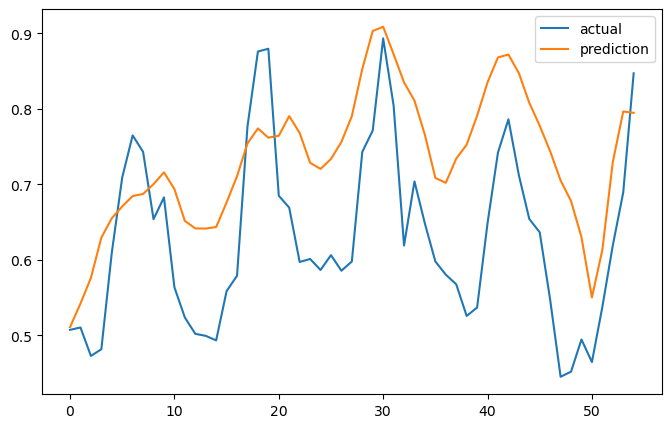

In [40]:
plt.figure(figsize=(8, 5))
plt.plot(np.asarray(y_test)[5:], label="actual")
plt.plot(pred, label="prediction")
plt.legend()
plt.show()